# Experiment 1: Performance
## How does the gazetteer-enhanced T5-ASP model perform compared to other NER models and in terms of contextual learning of entities?

### Datasets

In [2]:
import json

with open("/home/loebbert/projects/thesis/data/mlowner/lowner_train.json", encoding="utf-8") as file:
    lowner_train = json.load(file)

with open("/home/loebbert/projects/thesis/data/mlowner/lowner_dev.json", encoding="utf-8") as file:
    lowner_dev = json.load(file)

with open("/home/loebbert/projects/thesis/data/mlowner/lowner_test.json", encoding="utf-8") as file:
    lowner_test = json.load(file)

with open("/home/loebbert/projects/thesis/data/mlowner/lowner_gazetteer.json", encoding="utf-8") as file:
    lowner_gazetteer = json.load(file)

with open(
        "/home/loebbert/projects/thesis/data/multiconer/multiconer_test.json",
        encoding="utf-8") as file:
    multiconer_test = json.load(file)

In [8]:
datasets = [
    lowner_train, lowner_dev, lowner_test, lowner_gazetteer, multiconer_test,
    lowner_gazetteer + multiconer_test,
    lowner_train + lowner_gazetteer + multiconer_test
]
names = [
    "lowner_train",
    "lowner_dev",
    "lowner_test",
    "lowner_gazetteer",
    "multiconer_test",
    "lowner_gazetteer-multiconer_test",
    "lowner_train-lowner_gazetteer-multiconer_test",
]

### Dataset metrics

In [ ]:
from data_metrics.entity_coverage_ratio import confusion_matrix_expected_entity_coverage_ratio



cm_expected_entity_coverage = confusion_matrix_expected_entity_coverage_ratio(datasets, names)


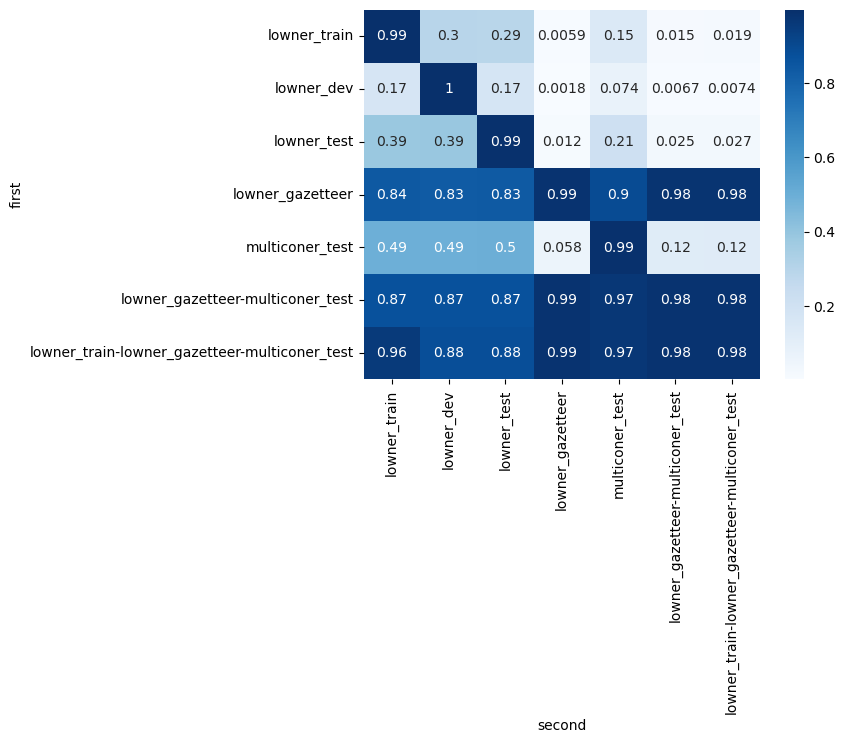

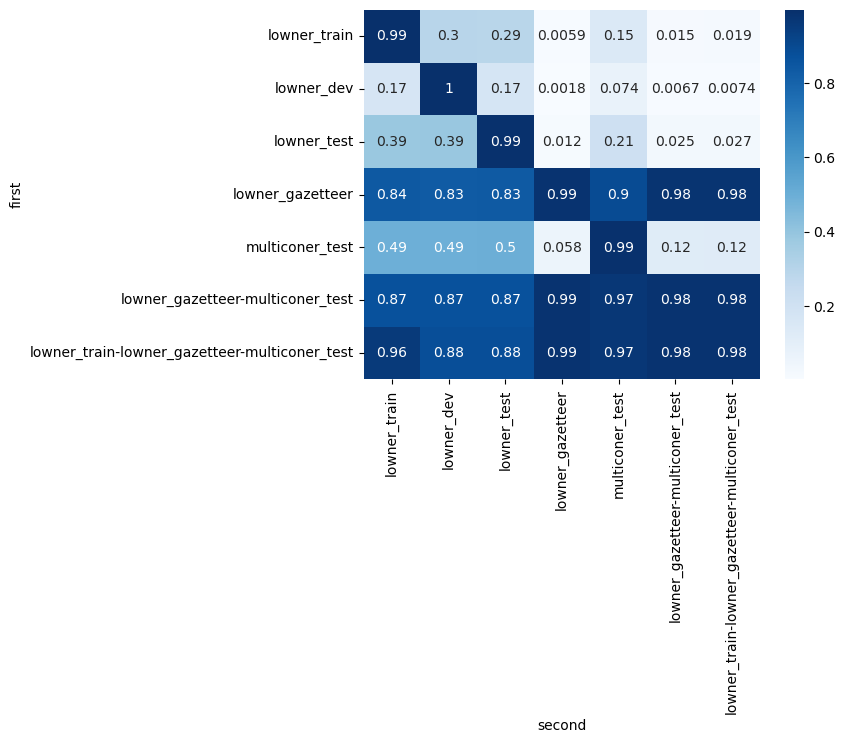

In [10]:
from data_metrics.utils import visualize_confusion_matrix

visualize_confusion_matrix(cm_expected_entity_coverage,
                           "expected_entity_coverage_ratio")

## Get expected entity coverage ratio for search results

In [14]:
import pandas as pd
import os

eecr_df = pd.read_pickle(os.path.join("/home/loebbert/projects/thesis", "experiments",
                         "01_performance", "search_result_eecr_df.pkl"))
eecr_df.head()

,dataset,model,doc_id,seed,eecr,targets
0,lowner_train,t5_asp_fetahugaz_sent,lowner_train_0,1,1.0,1
1,lowner_train,t5_asp_fetahugaz_sent,lowner_train_1,1,0.0,1
2,lowner_train,t5_asp_fetahugaz_sent,lowner_train_2,1,0.0,0
3,lowner_train,t5_asp_fetahugaz_sent,lowner_train_3,1,0.0,1
4,lowner_train,t5_asp_fetahugaz_sent,lowner_train_4,1,0.0,1


In [15]:
mean_df = eecr_df[eecr_df["targets"]>0].pivot_table(values="eecr",
                              index=["model", "dataset", "seed"],
                              aggfunc="mean").reset_index()
mean_df.head()

,model,dataset,seed,eecr
0,t5_asp_fetahugaz,lowner_dev,1,0.589858
1,t5_asp_fetahugaz,lowner_dev,2,0.589858
2,t5_asp_fetahugaz,lowner_dev,3,0.589858
3,t5_asp_fetahugaz,lowner_train,1,0.590047
4,t5_asp_fetahugaz,lowner_train,2,0.590047


In [4]:
mean_df_mean = mean_df.groupby(["model", "dataset"])["eecr"].mean().reset_index()
mean_df_std = mean_df.groupby(["model", "dataset"])["eecr"].std().reset_index()

In [5]:
mean_df_mean.pivot_table(values="eecr", index="model", columns="dataset")


dataset,lowner_dev,lowner_test,lowner_train
model,,,
t5_asp_fetahugaz,0.589858,0.596132,0.590047
t5_asp_fetahugaz_sent,0.643457,0.645171,0.643525
t5_asp_gaz,0.350800,0.355774,0.355272
t5_asp_gaz_sent,0.392492,0.399069,0.398991
t5_asp_sent,0.266483,0.267851,0.270596


In [6]:
mean_df_std.pivot_table(values="eecr", index="model", columns="dataset")

dataset,lowner_dev,lowner_test,lowner_train
model,,,
t5_asp_fetahugaz,0.0,0.0,0.0
t5_asp_fetahugaz_sent,0.0,0.0,0.0
t5_asp_gaz,0.0,0.0,0.0
t5_asp_gaz_sent,0.0,0.0,0.0
t5_asp_sent,0.0,0.0,0.0


### Context Coverage Ratio for Search results

In [25]:
import pandas as pd
import os

ccr_df = pd.read_pickle(
    os.path.join("/home/loebbert/projects/thesis", "experiments",
                 "01_performance", "search_result_ccr_df.pkl"))
ccr_df.head()

,dataset,model,seed,doc_id,cosine_full_max,cosine_full_mean,cosine_full_min,cosine_windowed_max,cosine_windowed_mean,cosine_windowed_min
0,lowner_train,t5_asp_fetahugaz_sent,1,lowner_train_0,0.656148,0.586906,0.415838,0.642543,0.514642,0.341941
1,lowner_train,t5_asp_fetahugaz_sent,1,lowner_train_1,0.696868,0.448836,0.067061,0.611117,0.418860,0.067061
2,lowner_train,t5_asp_fetahugaz_sent,1,lowner_train_2,0.561679,0.295702,0.030874,0.367668,0.176491,0.030874
3,lowner_train,t5_asp_fetahugaz_sent,1,lowner_train_3,0.631569,0.492404,0.305296,0.592315,0.419323,0.169089
4,lowner_train,t5_asp_fetahugaz_sent,1,lowner_train_4,0.482656,0.275889,0.013596,0.445746,0.242780,0.013596


In [2]:
def get_confusion_matrix_for_samples(df: pd.DataFrame, value: str):
    agg_df = df.pivot_table(values=value,
                                 index=["model", "dataset", "seed"],
                                 aggfunc="mean").reset_index()
    agg_mean_df = agg_df.groupby(
        ["model", "dataset"])[value].mean().reset_index()
    agg_std_df = agg_df.groupby(
        ["model", "dataset"])[value].std().reset_index()

    return agg_mean_df.pivot_table(values=value,
                                   index="model",
                                   columns="dataset"), agg_std_df.pivot_table(
                                       values=value,
                                       index="model",
                                       columns="dataset")


In [65]:
cm_eecr, _ = get_confusion_matrix_for_samples(eecr_df, "eecr")
cm_eecr

dataset,lowner_dev,lowner_test,lowner_train
model,,,
t5_asp_fetahugaz,0.501011,0.507653,0.499984
t5_asp_fetahugaz_sent,0.546537,0.549414,0.545299
t5_asp_gaz,0.297961,0.302970,0.301045
t5_asp_gaz_sent,0.333373,0.339839,0.338090
t5_asp_sent,0.226344,0.228097,0.229293


In [61]:
top1_full_ccr, _ = get_confusion_matrix_for_samples(ccr_df, "cosine_full_max")
topk_full_ccr, _ = get_confusion_matrix_for_samples(ccr_df, "cosine_full_mean")
top1_windowed_ccr, _ = get_confusion_matrix_for_samples(ccr_df, "cosine_windowed_max")
topk_windowed_ccr, _ = get_confusion_matrix_for_samples(
    ccr_df, "cosine_windowed_mean")
print(top1_full_ccr, top1_windowed_ccr, sep="\n\n", end="\n\n\n")
print(topk_full_ccr, topk_windowed_ccr, sep="\n\n")

dataset                lowner_dev  lowner_test  lowner_train
model                                                       
t5_asp_fetahugaz         0.509699     0.509369      0.506632
t5_asp_fetahugaz_sent    0.655171     0.654860      0.654014
t5_asp_gaz               0.439140     0.438694      0.437252
t5_asp_gaz_sent          0.639547     0.640249      0.639583
t5_asp_sent              0.633957     0.634750      0.634064

dataset                lowner_dev  lowner_test  lowner_train
model                                                       
t5_asp_fetahugaz         0.509699     0.509369      0.506632
t5_asp_fetahugaz_sent    0.609466     0.609333      0.608265
t5_asp_gaz               0.439140     0.438694      0.437252
t5_asp_gaz_sent          0.587355     0.588206      0.587806
t5_asp_sent              0.592531     0.592988      0.592951


dataset                lowner_dev  lowner_test  lowner_train
model                                                       
t5_asp_fetahugaz     

## Pearson correlation

In [21]:
from scipy.stats import pearsonr


def per_sample_pearsonr(first_df: pd.DataFrame,
                    second_df: pd.DataFrame,
                    model: str,
                    dataset: str,
                    first_metric: str,
                    second_metric: str,
                    alternative: str = "two-sided"):
    first_filtered = first_df[(first_df["model"] == model)
                   & (first_df["dataset"] == dataset)].groupby(
                       ["seed", "doc_id"]).mean(numeric_only=True)[first_metric]
    second_filtered = second_df[(second_df["model"] == model)
                                & (second_df["dataset"] == dataset)].groupby([
                                    "seed", "doc_id"
                                ]).mean(numeric_only=True)[second_metric]
    pearson_df = pd.concat([first_filtered, second_filtered], axis=1)
    # delete rows with nan
    filtered_pearson_df = pearson_df[(~pearson_df[first_metric].isna())
                                     & (~pearson_df[second_metric].isna())]

    return pearsonr(filtered_pearson_df[first_metric].tolist(),
                    filtered_pearson_df[second_metric].tolist(),
                    alternative=alternative), filtered_pearson_df


{'statistic': 0.4473335453699884, 'p-value': 0.0, 'confidence_interval': ConfidenceInterval(low=0.4419713240330716, high=0.4526637982056605)}


<Axes: xlabel='cosine_full_max', ylabel='eecr'>

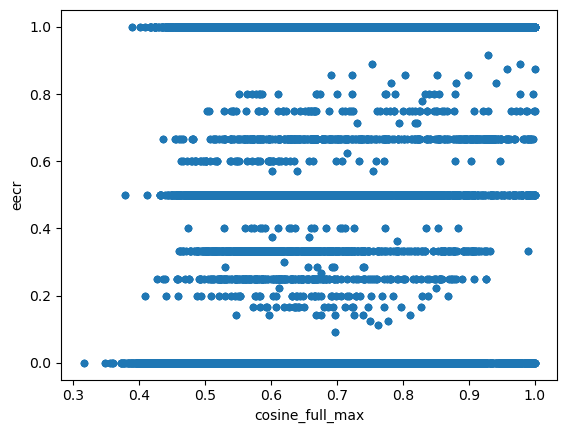

In [10]:
result, df = per_sample_pearsonr(eecr_df[eecr_df["targets"]>0], ccr_df, "t5_asp_sent", "lowner_test",
                                 "eecr", "cosine_full_max")
print({
    "statistic": result.statistic,
    "p-value": result.pvalue,
    "confidence_interval": result.confidence_interval()
})
df.plot(x="cosine_full_max", y="eecr", kind="scatter")


Based on the provided result:

- The correlation coefficient statistic is 0.46630310424701166. This indicates a moderate positive correlation between the variables, suggesting a relatively strong linear relationship between them.
- The p-value is 0.0. This indicates that the observed correlation is statistically significant at any reasonable significance level. The probability of obtaining such a strong correlation by chance alone is effectively zero.
- The confidence interval is given as [0.4614625602212253, 0.4711158850341081]. This range suggests that we can be 95% confident that the true correlation in the population falls within this interval. The narrow range indicates high precision in estimating the true correlation, and the confidence interval is entirely positive, reinforcing the interpretation of a strong positive correlation.

Considering the moderate positive correlation, statistically significant p-value, and narrow confidence interval, this result suggests a meaningful and robust correlation between the variables. It provides strong evidence of a linear relationship, allowing for reliable conclusions to be drawn based on the observed data.

In [20]:
def per_model_pearsonr(first_df: pd.DataFrame,
                         second_df: pd.DataFrame,
                         model: str,
                         first_metric: str,
                         second_metric: str,
                         alternative: str = "two-sided"):
    first_filtered = first_df[(first_df["model"] == model)].groupby(["seed", "doc_id"]).mean(numeric_only=True)[first_metric]
    second_filtered = second_df[(second_df["model"] == model)].groupby(
        ["seed", "doc_id"]).mean(numeric_only=True)[second_metric]
    pearson_df = pd.concat([first_filtered, second_filtered], axis=1)
    # delete rows with nan
    filtered_pearson_df = pearson_df[(~pearson_df[first_metric].isna())
                                     & (~pearson_df[second_metric].isna())]

    return pearsonr(filtered_pearson_df[first_metric].tolist(),
                    filtered_pearson_df[second_metric].tolist(),
                    alternative=alternative), filtered_pearson_df


def per_dataset_pearsonr(first_df: pd.DataFrame,
                         second_df: pd.DataFrame,
                         dataset: str,
                         first_metric: str,
                         second_metric: str,
                         alternative: str = "two-sided"):
    first_filtered = first_df[(first_df["dataset"] == dataset)].groupby(
        ["seed", "doc_id"]).mean(numeric_only=True)[first_metric]
    second_filtered = second_df[(second_df["dataset"] == dataset)].groupby(
        ["seed", "doc_id"]).mean(numeric_only=True)[second_metric]
    pearson_df = pd.concat([first_filtered, second_filtered], axis=1)
    # delete rows with nan
    filtered_pearson_df = pearson_df[(~pearson_df[first_metric].isna())
                                     & (~pearson_df[second_metric].isna())]

    return pearsonr(filtered_pearson_df[first_metric].tolist(),
                    filtered_pearson_df[second_metric].tolist(),
                    alternative=alternative), filtered_pearson_df

{'statistic': 0.4378891225996568, 'p-value': 0.0, 'confidence_interval': ConfidenceInterval(low=0.4334627063985018, high=0.4422944100769859)}


<Axes: xlabel='cosine_full_max', ylabel='eecr'>

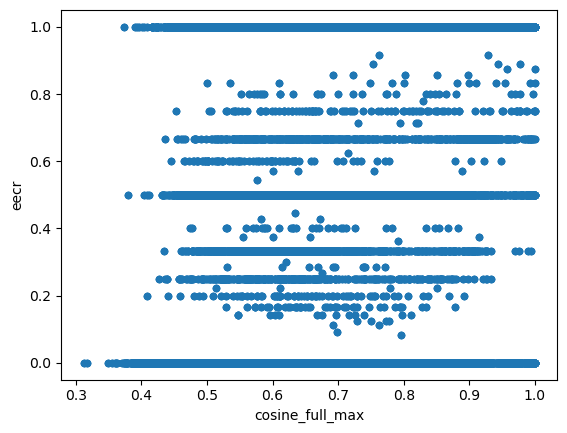

In [12]:
result, df = per_model_pearsonr(eecr_df[eecr_df["targets"] > 0], ccr_df,
                                "t5_asp_sent", "eecr", "cosine_full_max")
print({
    "statistic": result.statistic,
    "p-value": result.pvalue,
    "confidence_interval": result.confidence_interval()
})
df.plot(x="cosine_full_max", y="eecr", kind="scatter")


Based on the provided result:

- The correlation coefficient statistic is 0.45770827115305757. This indicates a moderate positive correlation between the variables, suggesting a relatively strong linear relationship between them.
- The p-value is 0.0. This indicates that the observed correlation is statistically significant at any reasonable significance level. The probability of obtaining such a strong correlation by chance alone is effectively zero.
- The confidence interval is given as [0.45078268209846245, 0.4645787592096722]. This range suggests that we can be 95% confident that the true correlation in the population falls within this interval. The narrow range indicates high precision in estimating the true correlation, and the confidence interval is entirely positive, further supporting the interpretation of a strong positive correlation.

Considering the moderate positive correlation, statistically significant p-value, and narrow confidence interval, this result suggests a meaningful and robust correlation between the variables. It provides strong evidence of a linear relationship, allowing for reliable conclusions to be drawn based on the observed data.

{'statistic': 0.4976375066114021, 'p-value': 0.0, 'confidence_interval': ConfidenceInterval(low=0.4925922484117189, high=0.5026493147420003)}


<Axes: xlabel='cosine_full_max', ylabel='eecr'>

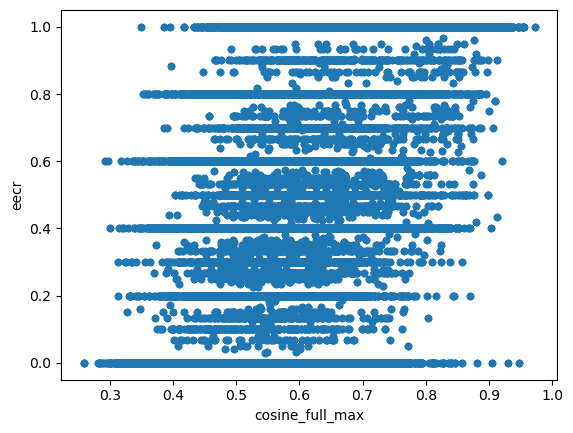

In [13]:
result, df = per_dataset_pearsonr(eecr_df[eecr_df["targets"] > 0], ccr_df,
                                  "lowner_test", "eecr", "cosine_full_max")
print({"statistic":result.statistic, "p-value":result.pvalue, "confidence_interval":result.confidence_interval()})
df.plot(x="cosine_full_max", y="eecr", kind="scatter")


Based on the provided result:

- The correlation coefficient statistic is 0.5350648828403948. This indicates a moderate to strong positive correlation between the variables, suggesting a relatively strong linear relationship between them.
- The p-value is 0.0. This indicates that the observed correlation is statistically significant at any reasonable significance level. The probability of obtaining such a strong correlation by chance alone is effectively zero.
- The confidence interval is given as [0.5273966364017278, 0.5426459637936389]. This range suggests that we can be 95% confident that the true correlation in the population falls within this interval. The narrow range indicates high precision in estimating the true correlation, and the confidence interval is entirely positive, further supporting the interpretation of a strong positive correlation.

Considering the strong positive correlation, statistically significant p-value, and narrow confidence interval, this result indicates a meaningful and robust correlation between the variables. It provides strong evidence of a linear relationship, allowing for reliable conclusions to be drawn based on the observed data. Overall, this is a solid and convincing result.

In [19]:
def overall_pearsonr(first_df: pd.DataFrame,
                     second_df: pd.DataFrame,
                     first_metric: str,
                     second_metric: str,
                     alternative: str = "two-sided"):
    first_filtered = first_df.groupby(["seed", "doc_id"
                                       ]).mean(numeric_only=True)[first_metric]
    second_filtered = second_df.groupby(
        ["seed", "doc_id"]).mean(numeric_only=True)[second_metric]
    pearson_df = pd.concat([first_filtered, second_filtered], axis=1)
    # delete rows with nan
    filtered_pearson_df = pearson_df[(~pearson_df[first_metric].isna())
                                     & (~pearson_df[second_metric].isna())]

    return pearsonr(filtered_pearson_df[first_metric].tolist(),
                    filtered_pearson_df[second_metric].tolist(),
                    alternative=alternative), filtered_pearson_df

{'statistic': 0.4940095601971694, 'p-value': 0.0, 'confidence_interval': ConfidenceInterval(low=0.4898682854360775, high=0.4981285406787908)}


<Axes: xlabel='cosine_full_max', ylabel='eecr'>

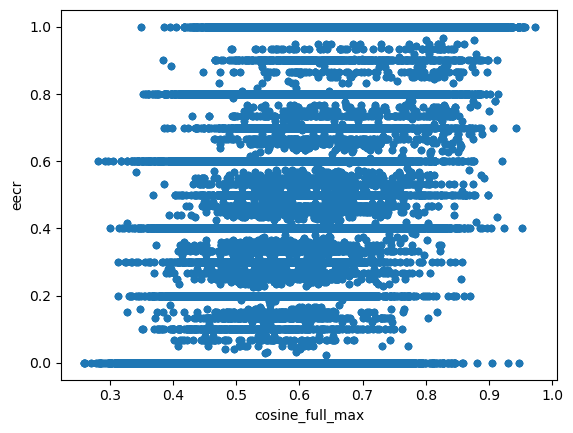

In [16]:
result, df = overall_pearsonr(eecr_df[eecr_df["targets"] > 0], ccr_df, "eecr",
                              "cosine_full_max")
print({
    "statistic": result.statistic,
    "p-value": result.pvalue,
    "confidence_interval": result.confidence_interval()
})
df.plot(x="cosine_full_max", y="eecr", kind="scatter")


Based on the provided result:

- The correlation coefficient statistic is 0.5327233226843386. This indicates a moderate to strong positive correlation between the variables, suggesting a relatively strong linear relationship between them.
- The p-value is 0.0. This indicates that the observed correlation is statistically significant at any reasonable significance level. The probability of obtaining such a strong correlation by chance alone is effectively zero.
- The confidence interval is given as [0.526444524769772, 0.5389440161823984]. This range suggests that we can be 95% confident that the true correlation in the population falls within this interval. The narrow range indicates high precision in estimating the true correlation, and the confidence interval is entirely positive, further supporting the interpretation of a strong positive correlation.

Considering the strong positive correlation, statistically significant p-value, and narrow confidence interval, this result indicates a meaningful and robust correlation between the variables. It provides strong evidence of a linear relationship, allowing for reliable conclusions to be drawn based on the observed data.

### Get table with models and datasets + respective correlations
```
dataset     lowner_train            ... overall
model                                   
t5_asp_gaz  per_sample_pearson_r        per_model_pearsonr
...
overall     per_dataset_pearsonr    ... overall_pearsonr
```

In [18]:
def pearson_correlation_table(first_df: pd.DataFrame,
                              second_df: pd.DataFrame,
                              first_metric: str,
                              second_metric: str,
                              alternative: str = "two-sided",
                              confidence_level: float = 0.95):
    total_key = "overall"

    datasets = set(
        first_df[(~first_df[first_metric].isna()
                  )]["dataset"].unique().tolist()).intersection(
                      set(second_df[(~second_df[second_metric].isna()
                                     )]["dataset"].unique().tolist()))
    datasets.add(total_key)
    models = set(first_df[(~first_df[first_metric].isna())]["model"].unique(
    ).tolist()).intersection(
        set(second_df[(
            ~second_df[second_metric].isna())]["model"].unique().tolist()))
    models.add(total_key)

    correlations = []
    for model in models:
        for dataset in datasets:
            if model == dataset == total_key:
                corr, _ = overall_pearsonr(first_df, second_df, first_metric, second_metric, alternative=alternative)
                conf = corr.confidence_interval(confidence_level=confidence_level)
                correlations.append({
                    "model": model,
                    "dataset": dataset,
                    "pcc": corr.statistic,
                    "p": corr.pvalue,
                    "confidence_low": conf.low,
                    "confidence_high": conf.high
                })
            elif model == total_key:
                corr, _ = per_dataset_pearsonr(first_df,
                                           second_df,
                                           dataset,
                                           first_metric,
                                           second_metric,
                                           alternative=alternative)
                conf = corr.confidence_interval(
                    confidence_level=confidence_level)
                correlations.append({
                    "model": model,
                    "dataset": dataset,
                    "pcc": corr.statistic,
                    "p": corr.pvalue,
                    "confidence_low": conf.low,
                    "confidence_high": conf.high
                })
            elif dataset == total_key:
                corr, _ = per_model_pearsonr(first_df,
                                               second_df,
                                               model,
                                               first_metric,
                                               second_metric,
                                               alternative=alternative)
                conf = corr.confidence_interval(
                    confidence_level=confidence_level)
                correlations.append({
                    "model": model,
                    "dataset": dataset,
                    "pcc": corr.statistic,
                    "p": corr.pvalue,
                    "confidence_low": conf.low,
                    "confidence_high": conf.high
                })
            else:
                corr, _ = per_sample_pearsonr(first_df,
                                             second_df,
                                             model,
                                             dataset,
                                             first_metric,
                                             second_metric,
                                             alternative=alternative)
                conf = corr.confidence_interval(
                    confidence_level=confidence_level)
                correlations.append({
                    "model": model,
                    "dataset": dataset,
                    "pcc": corr.statistic,
                    "p": corr.pvalue,
                    "confidence_low": conf.low,
                    "confidence_high": conf.high
                })

    correlations_df = pd.DataFrame.from_records(correlations)
    return correlations_df, correlations_df.pivot_table(values="pcc", index="model", columns="dataset")



In [19]:
correlation_table, cm = pearson_correlation_table(
    eecr_df[eecr_df["targets"] > 0],
    ccr_df,
    "eecr",
    "cosine_full_max",
    confidence_level=0.99)
cm


dataset,lowner_dev,lowner_test,lowner_train,overall
model,,,,
overall,0.493900,0.497638,0.484995,0.494010
t5_asp_fetahugaz,0.457904,0.469072,0.480902,0.471488
t5_asp_fetahugaz_sent,0.285973,0.282038,0.277760,0.281154
t5_asp_gaz,0.453536,0.473527,0.464368,0.469739
t5_asp_gaz_sent,0.382217,0.380631,0.361150,0.375558
t5_asp_sent,0.423388,0.447334,0.417703,0.437889


## Connect all the dots - Add training

In [3]:
import pandas as pd
import os

model_metrics_df = pd.read_pickle(
    os.path.join("experiments",
                 "01_performance", "model_metrics_df.pkl"))
# wrong score as it averages per sample f1 - need to calculate with tp, fp, fn
conf_matrix_f1, std = get_confusion_matrix_for_samples(model_metrics_df[model_metrics_df["targets"]>0], "f1")
conf_matrix_f1.sort_values("lowner_dev", ascending=False)

dataset,lowner_dev,lowner_train
model,,
t5_asp_fetahugaz_sent,0.870275,0.958187
t5_asp_gaz_sent,0.856644,0.962276
t5_asp_fetahugaz,0.853659,0.945863
t5_asp_gaz,0.841196,0.946719
t5_asp_sent,0.840317,0.948838
t5_asp,0.820362,0.946979


In [ ]:

correlation_table, cm = pearson_correlation_table(
    eecr_df[eecr_df["targets"] > 0],
    model_metrics_df[model_metrics_df["targets"]>0],
    "eecr",
    "f1",
    confidence_level=0.99)
cm


In [23]:
correlation_table

,model,dataset,pcc,p,confidence_low,confidence_high
0,t5_asp_gaz_sent,overall,0.104154,2.713405e-103,0.091808,0.116468
1,t5_asp_gaz_sent,lowner_train,0.082743,6.477367e-53,0.068879,0.096575
2,t5_asp_gaz_sent,lowner_dev,0.167010,1.087191e-54,0.139849,0.193920
3,t5_asp_sent,overall,0.092031,5.674268e-81,0.079658,0.104376
4,t5_asp_sent,lowner_train,0.078558,7.382748e-48,0.064686,0.092401
5,t5_asp_sent,lowner_dev,0.135978,1.116129e-36,0.108578,0.163172
6,t5_asp_fetahugaz,overall,0.209360,0.000000e+00,0.197410,0.221247
7,t5_asp_fetahugaz,lowner_train,0.180112,1.046048e-246,0.166587,0.193570
8,t5_asp_fetahugaz,lowner_dev,0.308830,6.340387e-189,0.283454,0.333774
9,t5_asp_fetahugaz_sent,overall,0.213230,0.000000e+00,0.201300,0.225097


In [26]:
correlation_table, cm = pearson_correlation_table(
    ccr_df,
    model_metrics_df[model_metrics_df["targets"] > 0],
    "cosine_full_max",
    "f1",
    confidence_level=0.99)
cm

dataset,lowner_dev,lowner_train,overall
model,,,
overall,0.159495,0.115758,0.121606
t5_asp_fetahugaz,0.127623,0.111971,0.111024
t5_asp_fetahugaz_sent,0.160550,0.113797,0.121746
t5_asp_gaz,0.095283,0.069151,0.072827
t5_asp_gaz_sent,0.154107,0.099583,0.110239
t5_asp_sent,0.150854,0.107166,0.115075


In [27]:
correlation_table

,model,dataset,pcc,p,confidence_low,confidence_high
0,t5_asp_gaz_sent,overall,0.110239,1.486694e-115,0.097908,0.122535
1,t5_asp_gaz_sent,lowner_train,0.099583,6.153626e-76,0.085758,0.113369
2,t5_asp_gaz_sent,lowner_dev,0.154107,9.778124e-47,0.126840,0.181142
3,t5_asp_sent,overall,0.115075,8.316107e-126,0.102758,0.127357
4,t5_asp_sent,lowner_train,0.107166,1.034486e-87,0.093362,0.120929
5,t5_asp_sent,lowner_dev,0.150854,7.779425e-45,0.123561,0.177918
6,t5_asp_fetahugaz,overall,0.111024,3.456248e-117,0.098696,0.123318
7,t5_asp_fetahugaz,lowner_train,0.111971,1.254678e-95,0.098181,0.125718
8,t5_asp_fetahugaz,lowner_dev,0.127623,1.772145e-32,0.100168,0.154884
9,t5_asp_fetahugaz_sent,overall,0.121746,1.094656e-140,0.109447,0.134007


In [1]:
import pandas as pd
import os

model_metrics_df = pd.read_pickle(
    os.path.join("experiments",
                 "01_performance", "model_metrics_df.pkl"))


,doc_id,targets,precision,recall,f1,error_type1,error_type2,error_type3,error_type4,error_type5,seed,dataset,checkpoint,model
0,lowner_train_5213,4,1.0,1.0,1.0,0,0,0,0,0,1,lowner_train,last,t5_asp_fetahugaz_sent
1,lowner_train_9106,4,1.0,1.0,1.0,0,0,0,0,0,1,lowner_train,last,t5_asp_fetahugaz_sent
2,lowner_train_12455,5,1.0,1.0,1.0,0,0,0,0,0,1,lowner_train,last,t5_asp_fetahugaz_sent
3,lowner_train_7124,12,1.0,1.0,1.0,0,0,0,0,0,1,lowner_train,last,t5_asp_fetahugaz_sent
4,lowner_train_13370,6,1.0,1.0,1.0,0,0,0,0,0,1,lowner_train,last,t5_asp_fetahugaz_sent


In [34]:

pivot = model_metrics_df[model_metrics_df["dataset"]=="lowner_dev"].pivot_table(index=["seed", "checkpoint", "model"], values=["error_type1", "error_type2", "error_type3", "error_type4", "error_type5"], aggfunc="sum")

In [35]:
pivot

error_type1  error_type2  error_type3  \
seed checkpoint model                                                          
1    best       t5_asp                         329          498           91   
                t5_asp_fetahugaz               319          409           44   
                t5_asp_fetahugaz_sent          283          396           31   
                t5_asp_gaz                     334          457           53   
                t5_asp_gaz_sent                321          419           51   
                t5_asp_sent                    350          417           60   
     last       t5_asp                         329          498           91   
                t5_asp_fetahugaz               319          409           44   
                t5_asp_fetahugaz_sent          283          396           31   
                t5_asp_gaz                     334          457           53   
                t5_asp_gaz_sent                317          428           52   
                t5_asp_sent                    307          454           59   
2    best       t5_asp                         343          491           81   
                t5_asp_fetahugaz               330          434           40   
                t5_asp_fetahugaz_sent          285          376           31   
                t5_asp_gaz                     341          453           49   
                t5_asp_gaz_sent                300          381           57   
                t5_asp_sent                    304          455           67   
     last       t5_asp                         343          491           81   
                t5_asp_fetahugaz               331          428           41   
                t5_asp_fetahugaz_sent          285          376           31   
                t5_asp_gaz                     341          453           49   
                t5_asp_gaz_sent                300          381           57   
                t5_asp_sent                    304          455           67   
3    best       t5_asp                         351          490           86   
                t5_asp_fetahugaz               329          423           39   
                t5_asp_fetahugaz_sent          279          391           28   
                t5_asp_gaz                     328          453           55   
                t5_asp_gaz_sent                317          393           50   
                t5_asp_sent                    293          442           63   
     last       t5_asp                         334          496           94   
                t5_asp_fetahugaz               329          423           39   
                t5_asp_fetahugaz_sent          279          391           28   
                t5_asp_gaz                     328          453           55   
                t5_asp_gaz_sent                317          393           50   
                t5_asp_sent                    319          419           67   

                                       error_type4  error_type5  
seed checkpoint model                                            
1    best       t5_asp                          23           94  
                t5_asp_fetahugaz                11           69  
                t5_asp_fetahugaz_sent            7           71  
                t5_asp_gaz                      19           88  
                t5_asp_gaz_sent                  9           88  
                t5_asp_sent                     21           89  
     last       t5_asp                          23           94  
                t5_asp_fetahugaz                11           69  
                t5_asp_fetahugaz_sent            7           71  
                t5_asp_gaz                      19           88  
                t5_asp_gaz_sent                 10           89  
                t5_asp_sent                     21           90  
2    best       t5_asp                          28           96  
        

In [36]:
import numpy as np
dist = pivot.loc[1].loc["best"].loc["t5_asp_fetahugaz_sent"].to_numpy()
percent_dist = np.round(dist / dist.sum(), 2)
percent_dist, dist

(array([0.36, 0.5 , 0.04, 0.01, 0.09]), array([283, 396,  31,   7,  71]))

In [26]:
from models.metrics import ASPMetrics
import pickle

with open(
        "/home/loebbert/projects/thesis/experiments/01_performance/data/seed_1/04_metrics/t5_asp_lownergaz_sent/last_lowner_dev.pkl",
        "rb") as file:
    metrics: ASPMetrics = pickle.load(file)
metrics_df = metrics.metrics_per_sample()

In [27]:
metrics_df.describe()

,targets,tp,fn,fp,precision,recall,f1,error_type1,error_type2,error_type3,error_type4,error_type5
count,3355.000000,3355.000000,3355.000000,3355.000000,3355.000000,3355.000000,3355.000000,3355.000000,3355.000000,3355.000000,3355.000000,3355.000000
mean,1.285544,1.132936,0.152608,0.121908,0.739704,0.742016,0.736744,0.085246,0.115648,0.012519,0.002385,0.022057
std,1.004826,1.004271,0.412197,0.366753,0.425018,0.424879,0.421767,0.304811,0.356860,0.113850,0.048780,0.154796
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,9.000000,3.000000,4.000000,1.000000,1.000000,1.000000,4.000000,3.000000,2.000000,1.000000,2.000000


In [23]:
tp = metrics_df["tp"].sum()
fp = metrics_df["fp"].sum()
fn = metrics_df["fn"].sum()
precision = tp / (fp + tp)
recall = tp / (fn + tp)
f1 = 2*precision*recall/(precision+recall)
precision, recall, f1

(0.9488636363636364, 0.9403153153153153, 0.9445701357466063)

In [24]:
metrics.precision(), metrics.recall(), metrics.f1()

(tensor(0.9489, device='cuda:0'),
 tensor(0.9403, device='cuda:0'),
 tensor(0.9446, device='cuda:0'))

In [1]:
from models.flair_roberta import get_lowner_dataset, train_model
import os
dataset = get_lowner_dataset()

res = train_model(
    os.path.join("/home/loebbert/projects/thesis", "experiments", "01_performance", "data"), dataset, 1)


/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-06-24 09:15:10,918 Reading data from /home/loebbert/projects/thesis/data/mlowner
2023-06-24 09:15:10,919 Train: /home/loebbert/projects/thesis/data/mlowner/train_lower.txt
2023-06-24 09:15:10,919 Dev: /home/loebbert/projects/thesis/data/mlowner/dev_lower.txt
2023-06-24 09:15:10,919 Test: /home/loebbert/projects/thesis/data/mlowner/test_lower.txt
2023-06-24 09:15:26,852 Computing label dictionary. Progress:


13424it [00:00, 101563.81it/s]

2023-06-24 09:15:26,986 Dictionary created for label 'ner' with 6 values: location (seen 6196 times), person (seen 5412 times), group (seen 2525 times), creative-work (seen 1960 times), corporation (seen 789 times), product (seen 486 times)


2023-06-24 09:15:31,054 SequenceTagger predicts: Dictionary with 13 tags: O, B-location, I-location, B-person, I-person, B-group, I-group, B-creative-work, I-creative-work, B-corporation, I-corporation, B-product, I-product


Global seed set to 1


2023-06-24 09:15:31,058 tensorboard logging path is /home/loebbert/projects/thesis/experiments/01_performance/data/lightning_logs
2023-06-24 09:15:31,067 ----------------------------------------------------------------------------------------------------
2023-06-24 09:15:31,069 Model: "SequenceTagger(
  (embeddings): TransformerWordEmbeddings(
    (model): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50266, 1024)
        (position_embeddings): Embedding(514, 1024, padding_idx=1)
        (token_type_embeddings): Embedding(1, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-23): 24 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key

  5%|▌         | 77/1403 [00:11<03:16,  6.74it/s]

In [1]:
import pickle

with open("/home/loebbert/projects/thesis/experiments/01_performance/data/seed_1/04_metrics/flair_roberta/train_results.pkl", "rb") as file:
    train_results = pickle.load(file)
train_results

{'test_score': 0.36830156461045566,
 'dev_score_history': [0.3610331575861045],
 'train_loss_history': [0.5753302779599645],
 'dev_loss_history': [0.25781378149986267]}

In [2]:
from flair.models import SequenceTagger
from models.flair_roberta import get_lowner_dataset
import os

dataset = get_lowner_dataset()

tagger = SequenceTagger.load(
    "/home/loebbert/projects/thesis/experiments/01_performance/data/seed_1/03_checkpoints/flair_roberta/best-model.pt"
)


2023-06-24 10:49:32,045 Reading data from /home/loebbert/projects/thesis/data/mlowner
2023-06-24 10:49:32,046 Train: /home/loebbert/projects/thesis/data/mlowner/train_lower.txt
2023-06-24 10:49:32,046 Dev: /home/loebbert/projects/thesis/data/mlowner/dev_lower.txt
2023-06-24 10:49:32,046 Test: /home/loebbert/projects/thesis/data/mlowner/test_lower.txt
2023-06-24 10:49:55,163 SequenceTagger predicts: Dictionary with 13 tags: O, B-location, I-location, B-person, I-person, B-group, I-group, B-creative-work, I-creative-work, B-corporation, I-corporation, B-product, I-product


100%|██████████| 29/29 [00:23<00:00,  1.24it/s]


IsADirectoryError: [Errno 21] Is a directory: '/home/loebbert/projects/thesis/experiments/01_performance/data/seed_1/04_metrics/flair_roberta'

In [3]:

dev_path = os.path.join("/home/loebbert/projects/thesis/experiments/01_performance/data/seed_1/04_metrics/flair_roberta", "dev_results.txt")
dev_res = tagger.evaluate(dataset.dev,
                          "ner",
                          out_path=dev_path,
                          return_loss=False,
                          mini_batch_size=120)


100%|██████████| 29/29 [00:26<00:00,  1.11it/s]

2023-06-24 10:51:19,290 Evaluating as a multi-label problem: False


In [1]:
from data_preparation.utils import json_to_bio, convert_bio_to_bmes

json_to_bio("/home/loebbert/projects/thesis/data/mlowner/lowner_train.json")
convert_bio_to_bmes(
    "/home/loebbert/projects/thesis/data/mlowner/lowner_train.bio")


In [6]:
def transform_entity_bio_labels_to_spans(label_sequence,
                                         classes_to_ignore=None):
    """
    Given a sequence of BMES-{entity type} labels, extracts spans.
    """
    spans = []
    classes_to_ignore = classes_to_ignore or []
    index = 0
    while index < len(label_sequence):
        label = label_sequence[index]
        if label[0] == "B":
            sign = 1
            start = index
            start_type = label.split("-")[1]
            while label[0] != "O":
                index += 1
                if index >= len(label_sequence):
                    spans.append((start, start, start_type))
                    sign = 0
                    break
                label = label_sequence[index]
                if not label[0] == "I":
                    spans.append((start, index, start_type))
                    sign = 0
                    break
                if label.split("-")[1] != start_type:
                    spans.append((start, start, start_type))
                    sign = 0
                    break
            if sign == 1:
                spans.append((start, index, start_type))
        else:
            if label != "O":
                pass
        index += 1
    return [span for span in spans if span[2] not in classes_to_ignore]


transform_entity_bio_labels_to_spans([
    "O", "O", "O", "O", "M-location", "O", "O", "B-location", "M-location", "E-location", "O",
    "O", "O", "O", "S-location", "O"
])


[(7, 10, 'location'), (14, 15, 'location')]

In [4]:
def get_ner_BMES(label_list):
    # list_len = len(word_list)
    # assert(list_len == len(label_list)), "word list size unmatch with label list"
    list_len = len(label_list)
    begin_label = 'B-'
    end_label = 'E-'
    single_label = 'S-'
    whole_tag = ''
    index_tag = ''
    tag_list = []
    stand_matrix = []
    for i in range(0, list_len):
        # wordlabel = word_list[i]
        current_label = label_list[i].upper()
        if begin_label in current_label:
            if index_tag != '':
                tag_list.append(whole_tag + ',' + str(i - 1))
            whole_tag = current_label.replace(begin_label, "",
                                              1) + '[' + str(i)
            index_tag = current_label.replace(begin_label, "", 1)

        elif single_label in current_label:
            if index_tag != '':
                tag_list.append(whole_tag + ',' + str(i - 1))
            whole_tag = current_label.replace(single_label, "",
                                              1) + '[' + str(i)
            tag_list.append(whole_tag)
            whole_tag = ""
            index_tag = ""
        elif end_label in current_label:
            if index_tag != '':
                tag_list.append(whole_tag + ',' + str(i))
            whole_tag = ''
            index_tag = ''
        else:
            continue
    if (whole_tag != '') & (index_tag != ''):
        tag_list.append(whole_tag)
    tag_list_len = len(tag_list)

    for i in range(0, tag_list_len):
        if len(tag_list[i]) > 0:
            tag_list[i] = tag_list[i] + ']'
            insert_list = reverse_style(tag_list[i])
            stand_matrix.append(insert_list)
    # print stand_matrix
    return stand_matrix


def reverse_style(input_string):
    target_position = input_string.index('[')
    input_len = len(input_string)
    output_string = input_string[target_position:input_len] + input_string[
        0:target_position]
    return output_string


get_ner_BMES([
    "O", "O", "O", "O", "B-location", "O", "O", "B-location", "M-location",
    "E-location", "O", "O", "O", "O", "S-location", "O"
])

['[4,6]LOCATION', '[7,9]LOCATION', '[14]LOCATION']

In [1]:
from data_preparation.knn_ner import get_lowner_bmes, get_multiconer_test_bmes, get_wnut_bmes

get_lowner_bmes()
get_wnut_bmes()
get_multiconer_test_bmes()


/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'test': '/home/loebbert/projects/thesis/data/multiconer/multiconer_sent.bmes'}

In [2]:
import argparse

config = {
    "lr": 5e-6,
    "max_epochs": 20,
    "max_length": 512,
    "weight_decay": 0.,
    "hidden_dropout_prob": 0.5,
    "warmup_proportion": 0.001,
    "train_batch_size": 40,
    "accumulate_grad_batches": 1,
    "save_topk": 1,
    "val_check_interval": 0.2,
    "bert_path": "xlm-roberta-large",
    "file_name": ".bmes",
    "data_dir": "/home/loebbert/projects/thesis/data/mlowner",
    "optimizer": "adamw",
    "save_ner_prediction": True,
    "classifier": "multi",
    "en_roberta": True,
    "gpus": 1
}
argparse.Namespace(**config)

Namespace(lr=5e-06, max_epochs=20, max_length=512, weight_decay=0.0, hidden_dropout_prob=0.5, warmup_proportion=0.001, train_batch_size=40, accumulate_grad_batches=1, save_topk=1, val_check_interval=0.2, bert_path='xlm-roberta-large', file_name='.bmes', data_dir='/home/loebbert/projects/thesis/data/mlowner', optimizer='adamw', save_ner_prediction=True, classifier='multi', en_roberta=True, gpus=1)

In [4]:
def transform_entity_bmes_labels_to_spans(label_sequence,
                                          classes_to_ignore=None):
    """
    Given a sequence of BMES-{entity type} labels, extracts spans.
    """
    spans = []
    classes_to_ignore = classes_to_ignore or []
    index = 0
    while index < len(label_sequence):
        label = label_sequence[index]
        if label[0] == "S":
            spans.append((index, index, label.split("-")[1]))
        elif label[0] == "B":
            sign = 1
            start = index
            start_cate = label.split("-")[1]
            while label[0] != "E":
                index += 1
                if index >= len(label_sequence):
                    spans.append((start, start, start_cate))
                    sign = 0
                    break
                label = label_sequence[index]
                if not (label[0] == "M" or label[0] == "E"):
                    spans.append((start, start, start_cate))
                    sign = 0
                    break
                if label.split("-")[1] != start_cate:
                    spans.append((start, start, start_cate))
                    sign = 0
                    break
            if sign == 1:
                spans.append((start, index, start_cate))
        else:
            if label != "O":
                pass
        index += 1
    return [span for span in spans if span[2] not in classes_to_ignore]


transform_entity_bmes_labels_to_spans(["O", "O", "O", "O", "O", "O", "O", "B-location", "E-location", "O", "O", "O", "O", "O","S-location", "O"])

[(7, 8, 'location'), (14, 14, 'location')]

In [6]:
from nltk import ngrams

item = ["bus", "services", "run", "to", "several", "neighboring", "towns", "."]
not_predicted = [[(idx, t) for idx, t in enumerate(item)]]
for n_gram_len in range(len(item), 1, -1):
    n_grams = []
    for available in not_predicted:
        if len(available) >= n_gram_len:
            n_grams.extend(ngrams(available, n_gram_len))
    print(n_grams)

[((0, 'bus'), (1, 'services'), (2, 'run'), (3, 'to'), (4, 'several'), (5, 'neighboring'), (6, 'towns'), (7, '.'))]
[((0, 'bus'), (1, 'services'), (2, 'run'), (3, 'to'), (4, 'several'), (5, 'neighboring'), (6, 'towns')), ((1, 'services'), (2, 'run'), (3, 'to'), (4, 'several'), (5, 'neighboring'), (6, 'towns'), (7, '.'))]
[((0, 'bus'), (1, 'services'), (2, 'run'), (3, 'to'), (4, 'several'), (5, 'neighboring')), ((1, 'services'), (2, 'run'), (3, 'to'), (4, 'several'), (5, 'neighboring'), (6, 'towns')), ((2, 'run'), (3, 'to'), (4, 'several'), (5, 'neighboring'), (6, 'towns'), (7, '.'))]
[((0, 'bus'), (1, 'services'), (2, 'run'), (3, 'to'), (4, 'several')), ((1, 'services'), (2, 'run'), (3, 'to'), (4, 'several'), (5, 'neighboring')), ((2, 'run'), (3, 'to'), (4, 'several'), (5, 'neighboring'), (6, 'towns')), ((3, 'to'), (4, 'several'), (5, 'neighboring'), (6, 'towns'), (7, '.'))]
[((0, 'bus'), (1, 'services'), (2, 'run'), (3, 'to')), ((1, 'services'), (2, 'run'), (3, 'to'), (4, 'several')), 

In [8]:
import random

x = set([1, 3, 4, 5])
random.choice(list(x))

4

In [17]:
from itertools import product
from datetime import datetime, timedelta
import os
import json

seeds = [1, 2, 3]
gazetteer_sizes = [2000, 4000, 6000, 8000]
error_percent_ratios = [0, 5, 10, 15]
erroneous_data_parts = ["train", "gazetteer", "both"]

thesis_path = "/home/loebbert/projects/thesis"

already_computed_path = os.path.join(thesis_path, "experiments",
                                         "02_content",
                                         "already_computed_runs.json")

with open(already_computed_path, "r") as file:
    already_computed = json.load(file)

hours_left = len(
    [(gaz_size, percent, part, seed)
     for gaz_size, percent, part, seed in product(
         gazetteer_sizes, error_percent_ratios, erroneous_data_parts, seeds)
     if [gaz_size, percent, part, seed] not in already_computed]) * 2

done_on_date = datetime.now() + timedelta(hours=hours_left)
done_on_date.strftime("%A %d.%m.%y %H:%M:%S"), hours_left

('Tuesday 04.07.23 20:03:04', 4)

In [3]:
import os
import json
import shutil
import smbclient
from tqdm import tqdm

client = smbclient.ClientConfig(username="pi", password="Donrosa1!")

thesis_path = "/home/loebbert/projects/thesis"

already_computed_path = os.path.join(thesis_path, "experiments", "02_content",
                                     "already_computed_runs.json")

with open(already_computed_path, "r") as file:
    already_computed = json.load(file)

src_data_path = os.path.join(thesis_path, "experiments", "02_content", "data")
dest_data_path = "//raspberrypi.local/studium/Masterarbeit/02_content"

for gaz_size, percent, part, seed in tqdm(already_computed):
    path_parts = [
        f"seed_{seed}", "03_checkpoints", f"size_{gaz_size}",
        f"error_ratio_{percent}", f"error_data_{part}"
    ]
    src_path = os.path.join(src_data_path, *path_parts)
    dest_path = os.path.join(dest_data_path, *path_parts)
    #print(dest_path)
    smbclient.makedirs(dest_path, exist_ok=True)
    ckpts = smbclient.listdir(dest_path, "*.ckpt")
    for ckpt in ["best", "last"]:
        src_ckpt_path = os.path.join(src_path, f"{ckpt}.ckpt")
        dest_ckpt_path = os.path.join(dest_path, f"{ckpt}.ckpt")
        if os.path.exists(src_ckpt_path) and f"{ckpt}.ckpt" not in ckpts:
            # copy
            with open(src_ckpt_path, "rb") as local_file:
                with smbclient.open_file(dest_ckpt_path, "wb") as rpi_file:
                    shutil.copyfileobj(local_file, rpi_file) # type: ignore
        ckpts = smbclient.listdir(dest_path, "*.ckpt")
        if os.path.exists(src_ckpt_path) and f"{ckpt}.ckpt" in ckpts:
            os.remove(src_ckpt_path)
        else:
            print("does not exist: " + src_ckpt_path)


 10%|█         | 15/144 [21:38<1:31:43, 42.66s/it] 

does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_2000/error_ratio_5/error_data_both/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_2000/error_ratio_5/error_data_both/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_2000/error_ratio_10/error_data_both/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_2000/error_ratio_10/error_data_both/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_2000/error_ratio_10/error_data_both/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_2000/error_ratio_10/error_data_both/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_2000/error_r

 24%|██▎       | 34/144 [21:38<20:57, 11.43s/it]  

does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_4000/error_ratio_15/error_data_both/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_4000/error_ratio_15/error_data_both/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_6000/error_ratio_0/error_data_both/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_6000/error_ratio_0/error_data_both/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_6000/error_ratio_0/error_data_both/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_6000/error_ratio_0/error_data_both/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_6000/error_rat

 35%|███▌      | 51/144 [21:38<07:35,  4.90s/it]

does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_8000/error_ratio_0/error_data_both/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_8000/error_ratio_5/error_data_both/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_8000/error_ratio_5/error_data_both/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_8000/error_ratio_5/error_data_both/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_8000/error_ratio_5/error_data_both/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_8000/error_ratio_5/error_data_both/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_8000/error_ratio

 48%|████▊     | 69/144 [21:39<02:44,  2.19s/it]

does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_2000/error_ratio_0/error_data_gazetteer/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_2000/error_ratio_0/error_data_gazetteer/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_4000/error_ratio_0/error_data_train/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_4000/error_ratio_0/error_data_train/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_4000/error_ratio_0/error_data_train/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_4000/error_ratio_0/error_data_train/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_40

 54%|█████▍    | 78/144 [21:39<01:38,  1.50s/it]

does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_8000/error_ratio_0/error_data_gazetteer/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_8000/error_ratio_0/error_data_gazetteer/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_2000/error_ratio_5/error_data_train/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_2000/error_ratio_5/error_data_train/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_2000/error_ratio_5/error_data_train/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_2000/error_ratio_5/error_data_train/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_20

 66%|██████▌   | 95/144 [21:39<00:36,  1.35it/s]

does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_2000/error_ratio_15/error_data_train/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_2000/error_ratio_15/error_data_train/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_2000/error_ratio_15/error_data_gazetteer/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_2000/error_ratio_15/error_data_gazetteer/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_2000/error_ratio_15/error_data_gazetteer/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_2000/error_ratio_15/error_data_gazetteer/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_check

 77%|███████▋  | 111/144 [21:39<00:12,  2.62it/s]

does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_4000/error_ratio_10/error_data_gazetteer/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_4000/error_ratio_10/error_data_gazetteer/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_4000/error_ratio_10/error_data_gazetteer/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_4000/error_ratio_10/error_data_gazetteer/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_4000/error_ratio_15/error_data_train/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_4000/error_ratio_15/error_data_train/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_check

 88%|████████▊ | 127/144 [21:39<00:03,  5.08it/s]

does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_6000/error_ratio_10/error_data_train/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_6000/error_ratio_10/error_data_train/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_6000/error_ratio_10/error_data_train/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_6000/error_ratio_10/error_data_train/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_6000/error_ratio_10/error_data_train/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_6000/error_ratio_10/error_data_gazetteer/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_

 99%|█████████▉| 143/144 [21:40<00:00,  9.59it/s]

does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_8000/error_ratio_5/error_data_train/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_8000/error_ratio_5/error_data_gazetteer/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_1/03_checkpoints/size_8000/error_ratio_5/error_data_gazetteer/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_8000/error_ratio_5/error_data_gazetteer/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_2/03_checkpoints/size_8000/error_ratio_5/error_data_gazetteer/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_8000/error_ratio_5/error_data_gazetteer/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpo

100%|██████████| 144/144 [21:40<00:00,  9.03s/it]

does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_8000/error_ratio_15/error_data_gazetteer/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/02_content/data/seed_3/03_checkpoints/size_8000/error_ratio_15/error_data_gazetteer/last.ckpt


In [1]:
# 01 performance experiment
import os
import json
import shutil
import smbclient
from tqdm import tqdm

client = smbclient.ClientConfig(username="pi", password="Donrosa1!")

thesis_path = "/home/loebbert/projects/thesis"


src_data_path = os.path.join(thesis_path, "experiments", "01_performance", "data")
dest_data_path = "//raspberrypi.local/studium/Masterarbeit/01_performance"

models = [
    "flair",
    "flair_gaz",
    "flair_gaz_sent",
    "flair_lownergaz",
    "flair_lownergaz_gaz",
    "flair_lownergaz_sent",
    "flair_sent",
    "t5_asp",
    "t5_asp_gaz",
    "t5_asp_gaz_sent",
    "t5_asp_lownergaz",
    "t5_asp_lownergaz_gaz",
    "t5_asp_lownergaz_sent",
    "t5_asp_sent",
]

for model in tqdm(models):
    for seed in [1, 2, 3]:
        path_parts = [
            f"seed_{seed}", "03_checkpoints", model
        ]
        src_path = os.path.join(src_data_path, *path_parts)
        dest_path = os.path.join(dest_data_path, *path_parts)
        #print(dest_path)
        smbclient.makedirs(dest_path, exist_ok=True)
        ckpts = smbclient.listdir(dest_path, "*.ckpt")
        for ckpt in ["best", "last"]:
            src_ckpt_path = os.path.join(src_path, f"{ckpt}.ckpt")
            dest_ckpt_path = os.path.join(dest_path, f"{ckpt}.ckpt")
            if os.path.exists(src_ckpt_path) and f"{ckpt}.ckpt" not in ckpts:
                # copy
                with open(src_ckpt_path, "rb") as local_file:
                    with smbclient.open_file(dest_ckpt_path, "wb") as rpi_file:
                        shutil.copyfileobj(local_file, rpi_file) # type: ignore
            ckpts = smbclient.listdir(dest_path, "*.ckpt")
            if os.path.exists(src_ckpt_path) and f"{ckpt}.ckpt" in ckpts:
                os.remove(src_ckpt_path)
            else:
                print("does not exist: " + src_ckpt_path)


 71%|███████▏  | 10/14 [12:53<02:33, 38.40s/it]  

does not exist: /home/loebbert/projects/thesis/experiments/01_performance/data/seed_1/03_checkpoints/t5_asp/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/01_performance/data/seed_1/03_checkpoints/t5_asp/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/01_performance/data/seed_2/03_checkpoints/t5_asp/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/01_performance/data/seed_2/03_checkpoints/t5_asp/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/01_performance/data/seed_3/03_checkpoints/t5_asp/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/01_performance/data/seed_3/03_checkpoints/t5_asp/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/01_performance/data/seed_1/03_checkpoints/t5_asp_gaz/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/01_performance/data/seed_1/03_checkpoints/t5_asp_gaz/last.ckpt
does not exist: /home/loebbert/projects/thesis/e

100%|██████████| 14/14 [12:53<00:00, 55.27s/it]

does not exist: /home/loebbert/projects/thesis/experiments/01_performance/data/seed_1/03_checkpoints/t5_asp_lownergaz_sent/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/01_performance/data/seed_1/03_checkpoints/t5_asp_lownergaz_sent/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/01_performance/data/seed_2/03_checkpoints/t5_asp_lownergaz_sent/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/01_performance/data/seed_2/03_checkpoints/t5_asp_lownergaz_sent/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/01_performance/data/seed_3/03_checkpoints/t5_asp_lownergaz_sent/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/01_performance/data/seed_3/03_checkpoints/t5_asp_lownergaz_sent/last.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/01_performance/data/seed_1/03_checkpoints/t5_asp_sent/best.ckpt
does not exist: /home/loebbert/projects/thesis/experiments/01_performance/data/

In [1]:
import sys
import os

thesis_path = "/home/loebbert/projects/thesis/"
sys.path.append(thesis_path)
thesis_path

'/home/loebbert/projects/thesis/'

In [24]:
from transformers.models.xlm_roberta import XLMRobertaTokenizer
from transformers.models.t5 import T5Tokenizer
xlm_tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")
word = ")"
xlm_subtokens = xlm_tokenizer.tokenize(word)
t5_subtokens = t5_tokenizer.tokenize(word)
xlm_subtokens, t5_subtokens

loading file sentencepiece.bpe.model from cache at /home/loebbert/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/sentencepiece.bpe.model
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /home/loebbert/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/77de1f7a7e5e737aead1cd880979d4f1b3af6668/config.json
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_att

(['▁)'], ['▁', ')'])

[3]

In [2]:
from functools import partial
from models.flair_roberta.metrics import SpanF1ForNER
from models.flair_roberta.dataset import BIONERDataset
from models.flair_roberta.utils import collate_to_max_length
from torch.utils.data import DataLoader, SequentialSampler
import json
with open(os.path.join(thesis_path, "data", "mlowner", "lowner_test.json"), "r") as file:
    test_dataset = json.load(file)
with open(
            os.path.join(thesis_path, "data", "mlowner", "lowner_types.json"),
            "r",
            encoding="utf-8",
        ) as file:
    types = list(json.load(file)["entities"].keys())
labels = BIONERDataset.get_labels(types)
dataset = BIONERDataset(labels, os.path.join(thesis_path, "data", "mlowner"), "lowner_test", "xlm-roberta-base")

metrics = SpanF1ForNER(labels)
sampler = SequentialSampler(dataset)
dataloader = DataLoader(
            dataset=dataset,
            sampler=sampler,
            batch_size=120,
            num_workers=0,
            collate_fn=partial(collate_to_max_length, fill_values=[0, 0, 0]),
            drop_last=False,
            persistent_workers=False,
            pin_memory=True,
        )
for batch in dataloader:
    idxs, word_maps, input_ids, gold_labels, label_seq_map = batch
    metrics.update(idxs, gold_labels, gold_labels, label_seq_map)

results = metrics.metrics.metrics_per_sample(test_dataset, types)
results


,doc_id,targets,entity_type,tp,fn,fp,error_type1,error_type2,error_type3,error_type4,error_type5
0,lowner_test_0,0,location,0,0,0,0,0,0,0,0
1,lowner_test_0,0,group,0,0,0,0,0,0,0,0
2,lowner_test_0,0,corporation,0,0,0,0,0,0,0,0
3,lowner_test_0,2,person,2,0,0,0,0,0,0,0
4,lowner_test_0,0,creative-work,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
201961,lowner_test_33660,0,group,0,0,0,0,0,0,0,0
201962,lowner_test_33660,0,corporation,0,0,0,0,0,0,0,0
201963,lowner_test_33660,0,person,0,0,0,0,0,0,0,0
201964,lowner_test_33660,0,creative-work,0,0,0,0,0,0,0,0


In [3]:
for doc in test_dataset:
    doc_id = doc["doc_id"]
    assert doc_id in metrics.metrics.predictions
    preds_set = set([
        (pred[0], pred[1] + 1,
            types[pred[2]] if isinstance(pred[2], int) else pred[2])
        for pred in metrics.metrics.predictions[doc_id]
    ])
    targets_set = set([(ent["start"], ent["end"], ent["type"])
                        for ent in doc["entities"]])
    tp = preds_set & targets_set
    fn = targets_set - preds_set
    fp = preds_set - targets_set
    if len(fn) > 0 or len(fp) > 0:
        print(doc_id, preds_set, targets_set, fn, fp)

In [ ]:
{"tokens": ["richmond", "had", "earlier", "been", "eliminated", "as", "a", "suspect", "because", "his", "campaign", "manager", "(", "kristin", "lehman", ")", ",", "with", "whom", "he", "was", "romantically", "involved", ",", "had", "provided", "him", "with", "an", "alibi", "."], "extended": ["richmond", "had", "earlier", "been", "eliminated", "as", "a", "suspect", "because", "his", "campaign", "manager", "(", "kristin", "lehman", ")", ",", "with", "whom", "he", "was", "romantically", "involved", ",", "had", "provided", "him", "with", "an", "alibi", "."], "entities": [{"type": "person", "start": 13, "end": 15}], "doc_id": "lowner_test_3"}

In [11]:
_, _, _, _, _, l = dataset[3]
l

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

In [7]:
metrics.metrics.predictions

{'lowner_test_0': [(8, 9, 'person'), (16, 17, 'person')],
 'lowner_test_1': [(7, 8, 'location'),
  (10, 10, 'location'),
  (20, 21, 'location'),
  (23, 23, 'location')],
 'lowner_test_2': [(7, 7, 'location'),
  (13, 13, 'location'),
  (15, 17, 'location')],
 'lowner_test_3': [(13, 15, 'person')],
 'lowner_test_4': [(15, 17, 'group')],
 'lowner_test_5': [(11, 14, 'location')],
 'lowner_test_6': [],
 'lowner_test_7': [(0, 1, 'person')],
 'lowner_test_8': [(5, 9, 'group')],
 'lowner_test_9': [(0, 1, 'corporation'), (3, 4, 'corporation')],
 'lowner_test_10': [(9, 9, 'location')],
 'lowner_test_11': [(21, 22, 'person')],
 'lowner_test_12': [(16, 17, 'product')],
 'lowner_test_13': [(11, 11, 'corporation'),
  (13, 14, 'corporation'),
  (22, 22, 'corporation')],
 'lowner_test_14': [(3, 3, 'location'), (8, 9, 'location')],
 'lowner_test_15': [(1, 3, 'creative-work'), (5, 7, 'person')],
 'lowner_test_16': [],
 'lowner_test_17': [(3, 4, 'location')],
 'lowner_test_18': [(20, 23, 'group')],
 'low

In [5]:
results["model"] = "flair"

In [6]:
agg_df = results.pivot_table(
        index=["model"],
        values=["tp", "fp", "fn"],
        aggfunc="sum",
    )
agg_df

,fn,fp,tp
model,,,
flair,644,644,43072


In [19]:
import pandas as pd
import pickle

with open("/home/loebbert/projects/thesis/hyperparameter_tuning/flair_lownergaz_sent_result.pkl", "rb") as file:
    flair_result = pickle.load(file)

df: pd.DataFrame = flair_result.get_dataframe()
df.sort_values(by="f1", ascending=False).head(5)[["f1", "logdir"]].to_dict()

2023-09-08 10:01:37,557	WARNING experiment_analysis.py:694 -- Failed to read the config for 1 trials:
- /home/loebbert/projects/thesis/hyperparameter_tuning/tune/flair_lownergaz_sent/run_training_a0742000_22_hidden_dropout_prob=0.1000,locked_dropout_prob=0.5000,lr=0.0000,train_search_dropout=0.3781,weight_decay=_2023-09-07_15-21-03


{'f1': {1: 0.8838000297546387,
  3: 0.8806999921798706,
  4: 0.8795999884605408,
  20: 0.878600001335144,
  15: 0.878600001335144},
 'logdir': {1: '/home/loebbert/projects/thesis/hyperparameter_tuning/tune/flair_lownergaz_sent/run_training_4f687f75_2_hidden_dropout_prob=0.2000,locked_dropout_prob=0.3000,lr=0.0000,train_search_dropout=0.0342,weight_decay=0_2023-09-07_11-36-16',
  3: '/home/loebbert/projects/thesis/hyperparameter_tuning/tune/flair_lownergaz_sent/run_training_0bf0e6a0_4_hidden_dropout_prob=0.1000,locked_dropout_prob=0.0000,lr=0.0000,train_search_dropout=0.1026,weight_decay=0_2023-09-07_12-10-35',
  4: '/home/loebbert/projects/thesis/hyperparameter_tuning/tune/flair_lownergaz_sent/run_training_0313aa18_5_hidden_dropout_prob=0.2000,locked_dropout_prob=0.3000,lr=0.0000,train_search_dropout=0.1368,weight_decay=0_2023-09-07_12-16-53',
  20: '/home/loebbert/projects/thesis/hyperparameter_tuning/tune/flair_lownergaz_sent/run_training_c4dfe2cb_21_hidden_dropout_prob=0.2000,locked